# **Simulación 1: Secretoma de *Fusobacterium nucleatum*+ MCF-7**

Esta primera simulación parte de obtener todos los metabólitos que secreta *Fusobacterium nucleatum* al medio. Estos metabolitos serán incorporados posteriormente al medio de crecimiento de MCF-7. 

<img src="exp_1.png" width="1000">

---
---
### **Importar paquetes**

In [ ]:
#!pip install micom

In [2]:
#pip show micom #para saber en donde esta ubicado el archivo de micom

De acuerdo con el script [1_community](https://github.com/resendislab/Modeling_Heterogeneity_Cancer_Metabolism_MICOM/tree/main/MICOM/Scripts): después de la instalación abrir el código de micom y modificar el archivo community.py. Línea de código 305 y modificar external ---> 'b'.

In [4]:
import micom
import pandas as pd
import numpy as np
import osqp
import pickle
import cobra
import cobra.io
import matplotlib.pyplot as plt
import logging
from pathlib import Path
from micom import load_pickle
from micom.media import minimal_medium
from micom.workflows import workflow
from micom import Community
from time import time
from cobra.flux_analysis import (single_gene_deletion, single_reaction_deletion)
from cobra.io import load_json_model, save_json_model, load_matlab_model, save_matlab_model, read_sbml_model, write_sbml_model

---
---

## **A. *Fusobacterium nucleatum***

### **1. Subir las reconstrucciones**

Como solo se trabajará unicamente con las reconstrucciones de *Fusobacterium nucleatum*, partimos de una carpeta en donde se van a almacenar todas las reconstrucciones que se encuentran en AGORA en formato SBML. Esta carpeta además de tener todas las reconstrucciones de interés debe de tener un archivo llamado manifest en formato *.csv*, que contiene toda la información de las bacterias.

<img src="carpeta-fuso.png" width="400" height="400"> <img src="ejemplomanifest.png" width="400" height="400">

#### **1.2. Convertir a un artifact qza**

Las reconstucciones de las bacterias están en formato .xml, para poder transformarlas a un artifacto qza debemos pasarlas a formato json para que lo pueda leer. Se debe pasar a un artifacto qza para poder verificar que el medio de crecimiento funcione. 

In [18]:
#qiime tools import --input-path AGORA_json  --output-path fn_reconst.qza  --type MetabolicModels[JSON]

El *--type* se cambia dependiendo de que datos partimos. En este caso son modelos metabólicos con archivos tipo **JSON*

### **2. Verificar el medio de cultivo**

El medio de cultivo con el que vamos a hacer las pruebas, este medio sabemos que corre. Es un medio de cultivo basado en leche materna, la cual se encuentra en los medios reportados de [micom/media](https://github.com/micom-dev/media?tab=readme-ov-file). 

In [7]:
import pandas as pd
medium_bm = pd.read_csv("medium_breastmilk.csv", index_col=False)
medium_bm

,reaction,metabolite,global_id,flux
0,EX_ala_L_m,ala_L_m,EX_ala_L(e),0.100000
1,EX_arg_L_m,arg_L_m,EX_arg_L(e),0.376962
2,EX_asp_L_m,asp_L_m,EX_asp_L(e),0.100000
3,EX_ca2_m,ca2_m,EX_ca2(e),7.500000
4,EX_cgly_m,cgly_m,EX_cgly(e),0.000823
...,...,...,...,...
177,EX_datp_m,datp_m,EX_datp(e),0.000238
178,EX_gtp_m,gtp_m,EX_gtp(e),0.001197
179,EX_nadp_m,nadp_m,EX_nadp(e),0.000031
180,EX_nh4_m,nh4_m,EX_nh4(e),0.030271


Una vez que subimos el medio de cultivo, con el workflow de verificar crecimiento, ponemos el medio de cultivo y el artifact que contiene las reconstrucciones.

In [19]:
from micom.workflows.db_media import check_db_medium

check = check_db_medium("fn_reconst.qza", medium_bm, threads=20)

Checking 7 genus-level models on a medium with 182 components.

Output()

In [20]:
check.can_grow.value_counts()

can_grow
True    7
Name: count, dtype: int64

Vemos que de las 7 bacterias (reconstrucciones), todas pueden crecer. Hacemos una grafica para ver la distribución del crecimiento. 

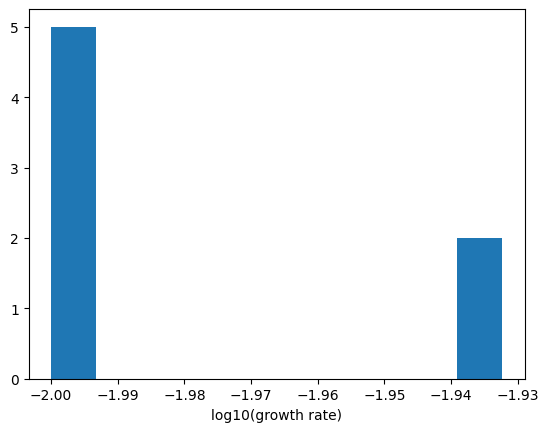

In [21]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np

plt.xlabel("log10(growth rate)")
plt.hist(np.log10(check.growth_rate[check.can_grow])) 
plt.show()

### **3. Construcción de la comunidad de *F. nucleatum***

#### **3.1. Subir la reconstrucción y abundancias de la comunidad**

In [26]:
import pandas as pd
data = pd.read_csv("abundancias-rel - data_fn.csv", index_col=False)
data

,id,genus,species,reaction,metabolites,file,sample_id,abundance
0,Fusobacterium_nucleatum_subsp_animalis_3_1_33,Fusobacterium,nucleatum,975,816,Fusobacterium_nucleatum_subsp_animalis_3_1_33.xml,T_01_A,5483
1,Fusobacterium_nucleatum_subsp_nucleatum_ATCC_2...,Fusobacterium,nucleatum,1097,865,Fusobacterium_nucleatum_subsp_nucleatum_ATCC_2...,T_01_A,328
2,Fusobacterium_nucleatum_subsp_vincentii_3_1_27,Fusobacterium,nucleatum,1021,822,Fusobacterium_nucleatum_subsp_vincentii_3_1_27...,T_01_A,373
3,Fusobacterium_nucleatum_subsp_animalis_3_1_33,Fusobacterium,nucleatum,975,816,Fusobacterium_nucleatum_subsp_animalis_3_1_33.xml,T_02_C,6019
4,Fusobacterium_nucleatum_subsp_nucleatum_ATCC_2...,Fusobacterium,nucleatum,1097,865,Fusobacterium_nucleatum_subsp_nucleatum_ATCC_2...,T_02_C,152
5,Fusobacterium_nucleatum_subsp_vincentii_3_1_27,Fusobacterium,nucleatum,1021,822,Fusobacterium_nucleatum_subsp_vincentii_3_1_27...,T_02_C,215
6,Fusobacterium_nucleatum_subsp_animalis_3_1_33,Fusobacterium,nucleatum,975,816,Fusobacterium_nucleatum_subsp_animalis_3_1_33.xml,T_07_A,6239
7,Fusobacterium_nucleatum_subsp_nucleatum_ATCC_2...,Fusobacterium,nucleatum,1097,865,Fusobacterium_nucleatum_subsp_nucleatum_ATCC_2...,T_07_A,57
8,Fusobacterium_nucleatum_subsp_vincentii_3_1_27,Fusobacterium,nucleatum,1021,822,Fusobacterium_nucleatum_subsp_vincentii_3_1_27...,T_07_A,39


Vamos a crear una comunidad con unicamente 3 *Fusobacterium nucleatum*, las cuales serán:
* FN_1: Fusobacterium_nucleatum_subsp_animalis_3_1_33
* FN_2: Fusobacterium_nucleatum_subsp_nucleatum_ATCC_25586
* FN_3: Fusobacterium_nucleatum_subsp_vincentii_3_1_27

In [9]:
bacterias = {'id': ['FN_1','FN_2','FN_3'],
    'file': ['Fusobacterium_nucleatum_subsp_animalis_3_1_33.xml','Fusobacterium_nucleatum_subsp_nucleatum_ATCC_25586.xml','Fusobacterium_nucleatum_subsp_vincentii_3_1_27.xml'],
     'abundance': [0.5739, 0.2739 ,0.1522]
    }

bacterias_fn = pd.DataFrame(data=bacterias)

#### **3.2. Creación de la comunidad**

In [13]:
FN = micom.Community (bacterias_fn, solver = "osqp")

Output()

In [14]:
print("build a community with a total of {} reactions.".format(len(FN.reactions)))

build a community with a total of 3243 reactions.


#### **3.3. Optimización de la comunidad**

In [15]:
solFN = FN.cooperative_tradeoff( fraction = 0.5, fluxes =True, pfba = True)
solFN

,abundance,growth_rate,reactions,metabolites
compartments,,,,
FN_1,0.5739,26.239817,973,917
FN_2,0.2739,12.523234,1097,985
FN_3,0.1522,6.958879,1035,939
medium,NaN,NaN,138,138


---
---
## **B. Modelo de MCF-7**

La reconstrucciónes de MCF-7 se obtuvieron del trabajo de **Modeling Cancer Metabolism Heterogeneity with MICOM** de Arellano y Resendis ([github aqui](https://github.com/resendislab/Modeling_Heterogeneity_Cancer_Metabolism_MICOM/tree/main)). En este trabajo, se identificaron 3 subpoblaciones de células en un esferoide de MCF-7:
* Modelo A - Invasive Population - I
* Modelo B - Reservoir Population - R
* Modelo C- Proliferating Population - P

### **1. Reconstrucciones de MCF-7**

In [5]:
A = cobra.io.read_sbml_model('models_cancer/modeloA.xml')
B = cobra.io.read_sbml_model('models_cancer/modeloB.xml')
C = cobra.io.read_sbml_model('models_cancer/modeloC.xml')

* El modelo **A** tiene:  982 metabolitos y 1126 reacciones
* El modelo **B** tiene:  616 metabolitos y 742 reacciones
* El modelo **C** tiene:  807 metabolitos y 1032 reacciones 

### **2. Comunidad**

In [9]:
tumor = {'id': ['A','B','C'],
    'file': ['models_cancer/modeloA.xml','models_cancer/modeloB.xml','models_cancer/modeloC.xml'],
     'abundance': [0.0977, 0.391,0.5113]
    }

MCF_7 = pd.DataFrame(data=tumor)

In [10]:
tumor = micom.Community (MCF_7, solver = "osqp")
print("build a community with a total of {} reactions.".format(len(tumor.reactions)))

Output()

build a community with a total of 2900 reactions.


In [12]:
tumor

Name,None
Memory address,7291b69ff5f0
Number of metabolites,2405
Number of reactions,2900
Number of genes,822
Number of groups,0
Objective expression,1.0*community_objective
Compartments,"b__A, c__A, m__A, x__A, g__A, e__A, r__A, n__A, l__A, i__A, b__B, c__B, m__B, r__B, x__B, l__B, n__B, e__B, i__B, b__C, c__C, x__C, m__C, r__C, n__C, l__C, e__C, i__C"


Creamos la comunidad a través de la combinación de las tres reconstrucciones de MCF-7.

#### **2.1 Optimización**

In [11]:
sol_tumor = tumor.cooperative_tradeoff( fraction = 0.9, fluxes =True, pfba = True)
sol_tumor

,abundance,growth_rate,reactions,metabolites
compartments,,,,
A,0.0977,0.022140,1126,982
B,0.3910,0.026672,742,616
C,0.5113,0.029761,1032,807
